## Pre-Lab analysis

New version to prelab analysis after improvements were given during Oral session.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
import numpy as np
import allantools
import os

figure_path = os.path.join(os.getcwd(), "figures")


### Allan deviation

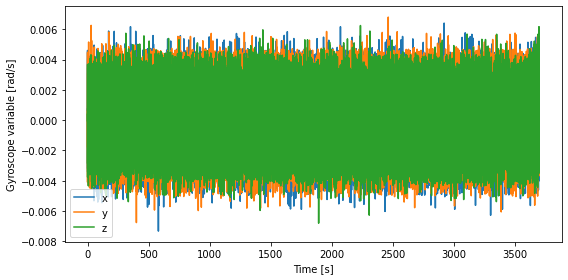

In [3]:

# data for allan deviation
data_allan = np.genfromtxt("Raw Data.csv", delimiter=",", skip_header=1)


# check if we get the time series as we wanted
labels = ["x", "y", "z"]

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

for i in range(1, 4):
    ax.plot(data_allan[:,0], data_allan[:,i], label=labels[i-1])

ax.set_xlabel("Time [s]")
ax.set_ylabel("Gyroscope variable [rad/s]")
ax.legend()


0.010078999966999999


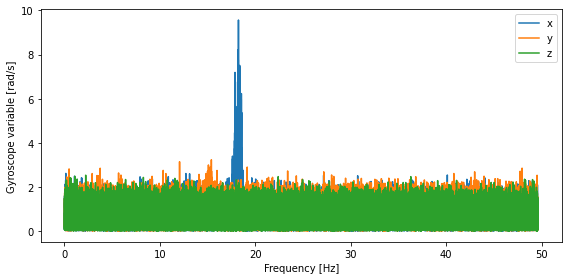

In [4]:
# now perform FFT

t_allan = data_allan[:,0]

N = len(t_allan)
# dt = t_allan[1] - t_allan[0]   # sampling rate
dt = t_allan[1] - t_allan[0]   # sampling rate
# dfreq = 1 / dt  # sampling rate
# print(dfreq)
print(dt)
freq = fftfreq(N, dt)[:N//2]

# check if we get the time series as we wanted
labels = ["x", "y", "z"]

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

for i in range(1, 4):
    y_fft = np.abs(fft(data_allan[:,i]))[:N//2]

    # print(np.mean(y_fft))

    # not so sure about normalization here...
    ax.plot(freq, y_fft, label=labels[i-1])

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Gyroscope variable [rad/s]")
ax.legend()


sample rate 99.21619240739503
slope (should be ~ -1/2): -0.40185614339716746, intercept: -2.8680867203237517, A: 0.056807511327108144
slope (should be ~ -1/2): -0.4436281261720194, intercept: -3.229397278436037, A: 0.039581348132469926
slope (should be ~ -1/2): -0.49075841014844634, intercept: -3.3409741961994004, A: 0.03540245198247689


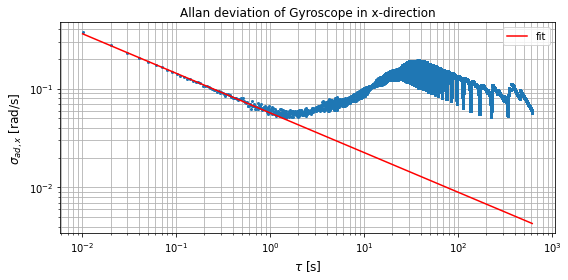

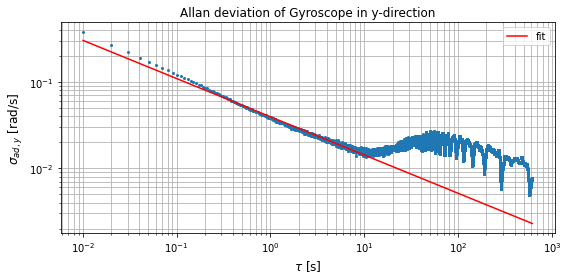

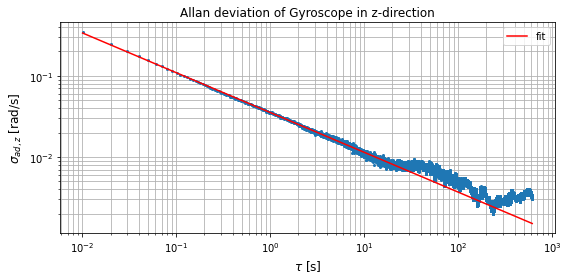

In [5]:
# derive allan deviation using allantools
from scipy.ndimage import uniform_filter1d

labels = ["x", "y", "z"]
cutoffs = [0.7, 8, 10]


dt = t_allan[1] - t_allan[0]   # sampling rate
dfreq = 1 / dt  # sampling rate
print("sample rate", dfreq)

# freq = fftfreq(N, dfreq)[:N//2]

# tau = np.logspace(0, 3, 50)

for i in range(1, 4):
    y_fft = np.abs(fft(data_allan[:,i]))[:N//2]

    # using oadev gives better results, but computation time is longer
    # adev is good enough for our case
    (t2, ad, ade, adn) = allantools.adev(y_fft, rate=dfreq, data_type="freq", taus=t_allan)

    # perform linear fit 
    # allan dev = A / np.sqrt(tau) so log(adev) = -1/2 tau + log(A)

    # first apply cutoff
    cutoff = cutoffs[i-1]
    ad_cutoff = ad[np.where(t2 <=cutoff)]
    t2_cutoff = t2[np.where(t2 <=cutoff)]

    # take log on both sidfes
    log_allandev = np.log(ad_cutoff)
    log_tau = np.log(t2_cutoff)

    # perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
    slope, logA = np.polyfit(log_tau, log_allandev, 1)

    print("slope (should be ~ -1/2): {0}, intercept: {1}, A: {2}".format(slope, logA, np.exp(logA)))


    # print results
    ad_thr = np.exp(logA) * t2**slope
    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.loglog(t2, ad, marker="o", ls="", ms=2.0)   # the data
    ax.loglog(t2, ad_thr, color="r", zorder=3, label = 'fit')

    ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
    ax.set_ylabel(r"$\sigma_{{ad, {0}}}$ [rad/s]".format(labels[i-1]), fontsize=12)
    ax.set_title("Allan deviation of Gyroscope in {0}-direction".format(labels[i-1]))
    ax.legend()
    ax.grid(which='both')

Below we used allantools.Dataset instead, yielding pretty good results as well.

error for allan dev  0.012683244318798217
slope (should be ~ -1/2): -0.3920648316623834, intercept: -1.0508448694416646, A: 0.34964222225882885
error for allan dev  0.00178117712065412
slope (should be ~ -1/2): -0.4498312896164985, intercept: -1.1608506357137998, A: 0.3132196317255526
error for allan dev  0.0008970632660866814
slope (should be ~ -1/2): -0.48215388356438776, intercept: -1.1258591022968714, A: 0.3243736774496296


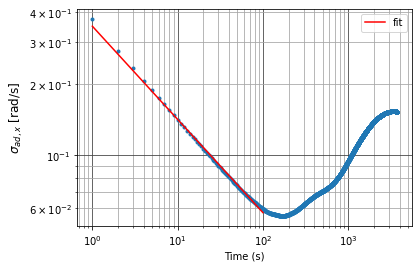

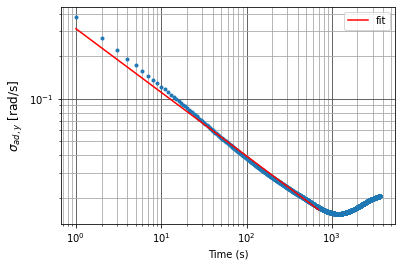

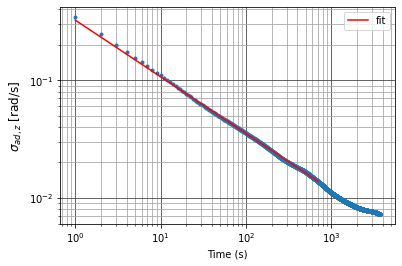

In [9]:
# derive allan deviation using allantools
# from scipy.ndimage import uniform_filter1d

labels = ["x", "y", "z"]

# fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

# tau = np.logspace(0, 3, 50)

for i in range(1, 4):
    y_fft = np.abs(fft(data_allan[:,i]))[:N//2]

    a = allantools.Dataset(y_fft, taus=t_allan, data_type="freq")
    result = a.compute("oadev")

    allan_dev = result["stat"]
    tau = result["taus"]
    int_err = result['stat_err'] * np.sqrt(tau)
    int_err_avg = np.mean(int_err)
    print("error for allan dev ", int_err_avg)

    cutoff = 700 if i > 1 else 100
    allan_dev = allan_dev[np.where(tau <=cutoff)]
    tau = tau[np.where(tau <=cutoff)]

    log_allandev = np.log(allan_dev)
    log_tau = np.log(tau)

    # perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
    slope, intercept = np.polyfit(log_tau, log_allandev, 1)

    print("slope (should be ~ -1/2): {0}, intercept: {1}, A: {2}".format(slope, intercept, np.exp(intercept)))

    # (t2, ad, ade, adn) = allantools.oadev(y_fft, rate=dfreq, data_type="freq", taus=t_allan)

    # ad = uniform_filter1d(ad, size=1)

    # ax.loglog(t2, ad)

    # print(np.mean(y_fft))

    # not so sure about normalization here...
    # ax.plot(freq, y_fft, label=labels[i-1])

    b = allantools.Plot()
    b.plot(a, errorbars=True, grid=True, marker='o', ls='', ms=3.0, zorder=2)
    plt.loglog(tau, np.exp(intercept) * tau**slope, color="r", zorder=3, label = 'fit')

    
    b.ax.set_xlabel("Time (s)")
    b.ax.set_ylabel(r"$\sigma_{{ad, {0}}}$ [rad/s]".format(labels[i-1]), fontsize=12)
    b.ax.legend()

# b.ax.set_xlim(xmin=0)

## Rotation of Earth

In [7]:
# import data for both data (flip up and flip down)

# "Time (s)","Gyroscope x (rad/s)","Gyroscope y (rad/s)","Gyroscope z (rad/s)","Absolute (rad/s)"
data_earth_180 = np.genfromtxt('Raw Data 180.csv', delimiter=",", skip_header=1)
data_earth_0 = np.genfromtxt('Raw Data 0.csv', delimiter=",", skip_header=1)

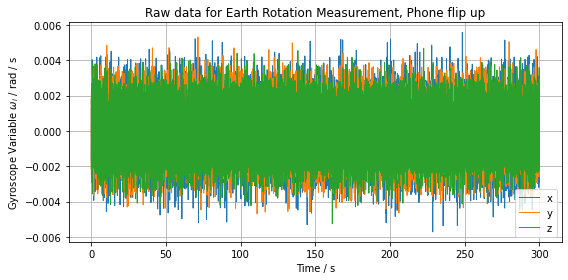

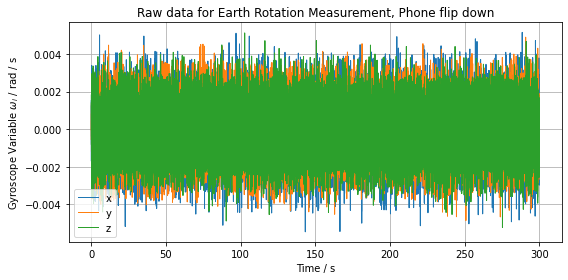

In [24]:
# plot the time series for each measurement
labels = ["x", "y", "z"]
# colors = ["r", "b", "g"]
flips = ["up", "down"]

time_avgs = np.zeros((3,2))

for j, data in enumerate([data_earth_0, data_earth_180]):
    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    for i in range(3):
        ax.plot(data[:,0], data[:,i+1], label=labels[i], lw=1.0, ms=3.0)
        time_avgs[i,j] = np.mean(data[:,i+1])  # store temporal average of each data
        
    ax.set_xlabel("Time / s")
    ax.set_ylabel("Gyroscope Variable $\omega_i$ / rad / s")
    ax.set_title("Raw data for Earth Rotation Measurement, Phone flip {0}".format(flips[j]))

    ax.legend()
    ax.grid()

In [30]:
# now calculate temporal average 

time_diff = np.abs(time_avgs[:,0] - time_avgs[:,1]) / 2.

# evaluate rotation of earth by normalizing by projection 
proj_ang = np.deg2rad(39.2536)
earth_rot = time_diff / np.cos(proj_ang)

# calculate the magnitude of the temporal difference and earth rotation rate
time_diff_mag = np.linalg.norm(time_diff)
earth_rot_mag = np.linalg.norm(earth_rot)

# print results
print("Rotation Rate of Earth in x: {0} rad/s, {1} rad/s, {2} rad/s".format(*earth_rot))
print("Magnitude of rotation rate: {0} rad / s".format(earth_rot_mag))


Rotation Rate of Earth in x: 3.182477795310088e-05 rad/s, 3.635003835537061e-05 rad/s, 4.335868643221686e-06 rad/s
Magnitude of rotation rate: 4.8507128724470626e-05 rad / s
